## Figure 7

Analysis of feature correlation in topological featurization and use of featurization by extracting the largest subtribes in volumetric samples

In [1]:
from toposample import Config, data, TopoData
from toposample.data import read_h5_dataset, read_multiple_h5_datasets
from figure_helper import FigureHelper
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from plot_helpers import adjust_color_brightness
import json
import h5py
import numpy

"""
Paths to relevant data.
"""
cfg = Config("../working_dir/config/common_config.json")
fn_features = cfg._cfg['analyzed']['features']
fn_features_acc = cfg._cfg['analyzed']['classifier_features_results']

"""
Additional parameterization, like which examples to plot and in which color
"""
# Panel-A
param_spec_sel = ['Adjacency spectral gap (low)', 'Efferent extension rate'] # Two examples of specifiers (parameter sampling) with low/high correlation

# Panel-B/C/D/E
col_param = 'tab:green' # Color for parameter sampling
col_vol = 'tab:blue' # Color for volumetric sampling
col_subtr = 'tab:red' # Color for subtribes in volumetric samples

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 7")

In [2]:
"""
Loading the data
"""
# Load features (Euler characteristic values)
num_stimuli = 8
read_features = read_multiple_h5_datasets({f"stim{idx}": f"per_stimulus/stim{idx}" for idx in range(num_stimuli)})
ec_ftr = TopoData(fn_features, follow_link_functions={"data_fn": (read_features, True)})["data_fn"]
ec_ftr = ec_ftr.filter(index='0') # Assume that features are pooled to a single element at index '0'

# Merge feature trials of all stimuli
f_cat2 = lambda x: numpy.concatenate([x[k] for k in x.keys()], 2) # Concatenate along dim 2 (=trials)
ec_ftr = ec_ftr.map(f_cat2)

# Accuracies
read_scores = read_h5_dataset("scores")
ftr_acc = TopoData(fn_features_acc, follow_link_functions={"data_fn": (read_scores, True)})["data_fn"]
ftr_acc = ftr_acc.filter(index='0') # Assume that results are pooled to a single element at index '0'


In [3]:
"""
Some analysis of the data
"""
# Feature (Euler characteristic) correlation
f_cc = lambda x: numpy.nanmean([numpy.corrcoef(x[:, :, trial].T) for trial in range(x.shape[2])], 0) # Pairwise correlation within single trials, then mean over trials
ec_cc = ec_ftr.map(f_cc)

f_pw_mean = lambda x: numpy.sum(numpy.triu(x, 1)) / ((numpy.prod(x.shape) - x.shape[0]) / 2) # Mean over pairwise correlation matrix
ec_mcc = ec_cc.map(f_pw_mean)

# Mean accuracy over CV repetitions
ftr_acc = ftr_acc.map(numpy.nanmean)

/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


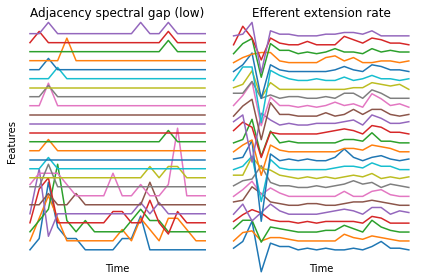

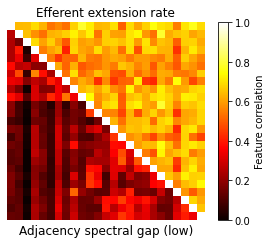

In [4]:
"""
Panel A: Two examples of sets of tribes with uncorrelated and highly correlated features
"""
# Alternative 1: Feature values over time
fig = plt.figure(figsize=(6, 4))
trial_sel = 0
ftr_sel = [ec_ftr.get2(sampling='Parameter', specifier=param_spec_sel[idx])[:, :, trial_sel] for idx in range(len(param_spec_sel))]
for sel_idx, ftr in enumerate(ftr_sel):
    plt.subplot(1, len(ftr_sel), sel_idx + 1)
    offset = (ftr.max() - ftr.min()) * 0.1
    for ftr_idx in range(ftr.shape[1]):
        plt.plot(ftr[:, ftr_idx] + ftr_idx * offset, clip_on=False)
    plt.title(param_spec_sel[sel_idx])
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.xlabel('Time')
    plt.ylim((-offset, (ftr.shape[1] - 1) * offset + ftr[:, -1].max()))
    if sel_idx == 0:
        plt.ylabel('Features')
plt.tight_layout()
F.save(fig, "Panel-A1")

# Alternative 2: Pairwise feature correlation matrices (2 examples combined)
assert len(param_spec_sel) == 2, 'ERROR: Two specifiers required!'
fig = plt.figure(figsize=(4, 3.5))
cc_mat1 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[0])
cc_mat2 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[1])
cc_mat_comb = numpy.tril(cc_mat1, 0) + numpy.triu(cc_mat2, 1)
plt.imshow(cc_mat_comb, clim=(0, 1), cmap=cm.hot)
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.xlabel(param_spec_sel[0], fontsize=12)
plt.title(param_spec_sel[1], fontsize=12)
plt.tight_layout()
plt.colorbar(label='Feature correlation')
F.save(fig, "Panel-A2")

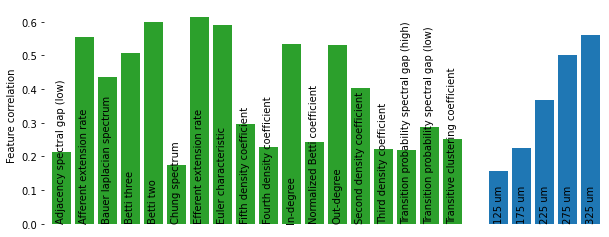

In [5]:
"""
Panel B: Average feature correlation for champion and volumetric samples
"""
specs_param = ec_mcc.filter(sampling='Parameter').labels_of('specifier')
specs_vol = ec_mcc.filter(sampling='Radius').labels_of('specifier')

fig = plt.figure(figsize=(10, 4))
ax = fig.gca()
ax.bar(range(len(specs_param)), [ec_mcc.get2(sampling='Parameter', specifier=spec) for spec in specs_param], color=col_param)
ax.bar(range(len(specs_param) + 1, len(specs_param) + len(specs_vol) + 1), [ec_mcc.get2(sampling='Radius', specifier=spec) for spec in specs_vol], color=col_vol)

ax.set_xticks(list(range(len(specs_param))) + list(range(len(specs_param) + 1, len(specs_param) + len(specs_vol) + 1)))
ax.set_xticklabels(specs_param + specs_vol, rotation='vertical', va='bottom')
ax.tick_params(axis='x', length=0, pad=-1)
ax.set_ylabel('Feature correlation')
ax.set_xlim((-0.75, len(specs_param) + len(specs_vol) + 0.5))
plt.box(False)
F.save(fig, "Panel-B")

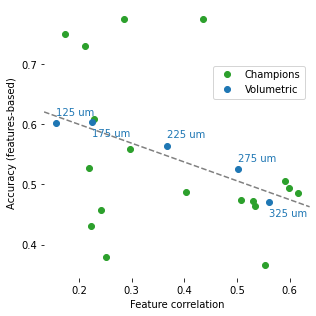

In [6]:
"""
Panel C: High average correlation leads to poor classification
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
for x, spec in enumerate(specs_param):
    data_mcc = ec_mcc.get2(sampling='Parameter', specifier=spec)
    data_acc = ftr_acc.get2(sampling='Parameter', specifier=spec)
    ax.plot(data_mcc, data_acc, marker='o', ls='None', color=col_param, label='Champions' if x==0 else '')
    all_x.append(data_mcc)
    all_y.append(data_acc)

spec_va = ['bottom', 'top', 'bottom', 'bottom', 'top']
for x, spec in enumerate(specs_vol):
    data_mcc = ec_mcc.get2(sampling='Radius', specifier=spec)
    data_acc = ftr_acc.get2(sampling='Radius', specifier=spec)
    ax.plot(data_mcc, data_acc, marker='o', ls='None', color=col_vol, label='Volumetric' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.01
    elif spec_va[x] == 'top':
        y_offset = -0.01
    else:
        y_offset = 0.0
    ax.text(data_mcc, data_acc + y_offset, spec, ha='left', va=spec_va[x], color=col_vol)
    all_x.append(data_mcc)
    all_y.append(data_acc)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit[1] + data_fit[0] * x_range, color='grey', ls='--')
plt.box(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.8))
plt.tight_layout()
F.save(fig, "Panel-C")

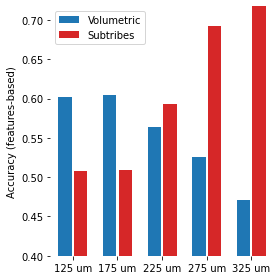

In [7]:
"""
Panel D: Overview of accuracies when using the largest 25 subtribes in volumetric samples
"""
specs_subtr = [spec + '@0' for spec in specs_vol] # Select first set of subtribes (..@0)
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
ax.bar(numpy.arange(len(specs_vol)) - 0.175, [ftr_acc.get2(sampling='Radius', specifier=spec) for spec in specs_vol], width=0.3, color=col_vol, label='Volumetric')
ax.bar(numpy.arange(len(specs_subtr)) + 0.175, [ftr_acc.get2(sampling='subtribes', specifier=spec) for spec in specs_subtr], width=0.3, color=col_subtr, label='Subtribes')
ax.autoscale(tight=True)
ax.set_ylim((0.4, max(ax.get_ylim())))
ax.set_xticks(range(len(specs_vol)))
ax.set_xticklabels(specs_vol)
ax.set_ylabel('Accuracy (features-based)')
ax.set_xlim((-0.5, len(specs_vol) - 0.5))
plt.legend(loc='upper left')
plt.box(False)
plt.tight_layout()
F.save(fig, "Panel-D")

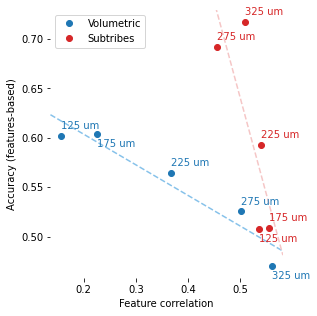

In [8]:
"""
Panel E: Feature correlation vs accuracy based on subtribes in volumetric samples
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
spec_va = ['bottom', 'top', 'bottom', 'bottom', 'top']
for x, spec in enumerate(specs_vol):
    data_mcc = ec_mcc.get2(sampling='Radius', specifier=spec)
    data_acc = ftr_acc.get2(sampling='Radius', specifier=spec)
    ax.plot(data_mcc, data_acc, marker='o', ls='None', color=col_vol, label='Volumetric' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(data_mcc, data_acc + y_offset, spec, ha='left', va=spec_va[x], color=col_vol)
    all_x.append(data_mcc)
    all_y.append(data_acc)

data_fit_vol = numpy.polyfit(all_x, all_y, deg=1)

all_x = []
all_y = []
spec_va = ['top', 'bottom', 'bottom', 'bottom', 'bottom']
for x, spec in enumerate(specs_subtr):
    data_mcc = ec_mcc.get2(sampling='subtribes', specifier=spec)
    data_acc = ftr_acc.get2(sampling='subtribes', specifier=spec)
    ax.plot(data_mcc, data_acc, marker='o', ls='None', color=col_subtr, label='Subtribes' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(data_mcc, data_acc + y_offset, specs_vol[x], ha='left', va=spec_va[x], color=col_subtr)
    all_x.append(data_mcc)
    all_y.append(data_acc)

data_fit_subtr = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit_vol[1] + data_fit_vol[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_vol), 1.75), ls='--')
ax.plot(x_range, data_fit_subtr[1] + data_fit_subtr[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_subtr), 1.75), ls='--')
plt.box(False)
plt.legend(loc='upper left')
plt.tight_layout()
F.save(fig, "Panel-E")